In [ ]:
# Alexnet 30 Epoch, training 80%, testing 20%
# Learning Rate 0.00001

Epoch [1/30], Train Loss: 0.6834, Train Accuracy: 58.67%, Validation Loss: 0.6689, Validation Accuracy: 60.60%, Time per Epoch: 44.79 seconds
Epoch [2/30], Train Loss: 0.6675, Train Accuracy: 58.67%, Validation Loss: 0.6369, Validation Accuracy: 62.50%, Time per Epoch: 21.42 seconds
Epoch [3/30], Train Loss: 0.6133, Train Accuracy: 65.45%, Validation Loss: 0.5584, Validation Accuracy: 71.40%, Time per Epoch: 21.59 seconds
Epoch [4/30], Train Loss: 0.5479, Train Accuracy: 72.00%, Validation Loss: 0.5412, Validation Accuracy: 72.00%, Time per Epoch: 20.39 seconds
Epoch [5/30], Train Loss: 0.5106, Train Accuracy: 75.48%, Validation Loss: 0.4896, Validation Accuracy: 75.90%, Time per Epoch: 21.01 seconds
Epoch [6/30], Train Loss: 0.4874, Train Accuracy: 76.78%, Validation Loss: 0.4684, Validation Accuracy: 78.40%, Time per Epoch: 22.10 seconds
Epoch [7/30], Train Loss: 0.4641, Train Accuracy: 78.65%, Validation Loss: 0.4319, Validation Accuracy: 80.10%, Time per Epoch: 21.89 seconds
Epoch 

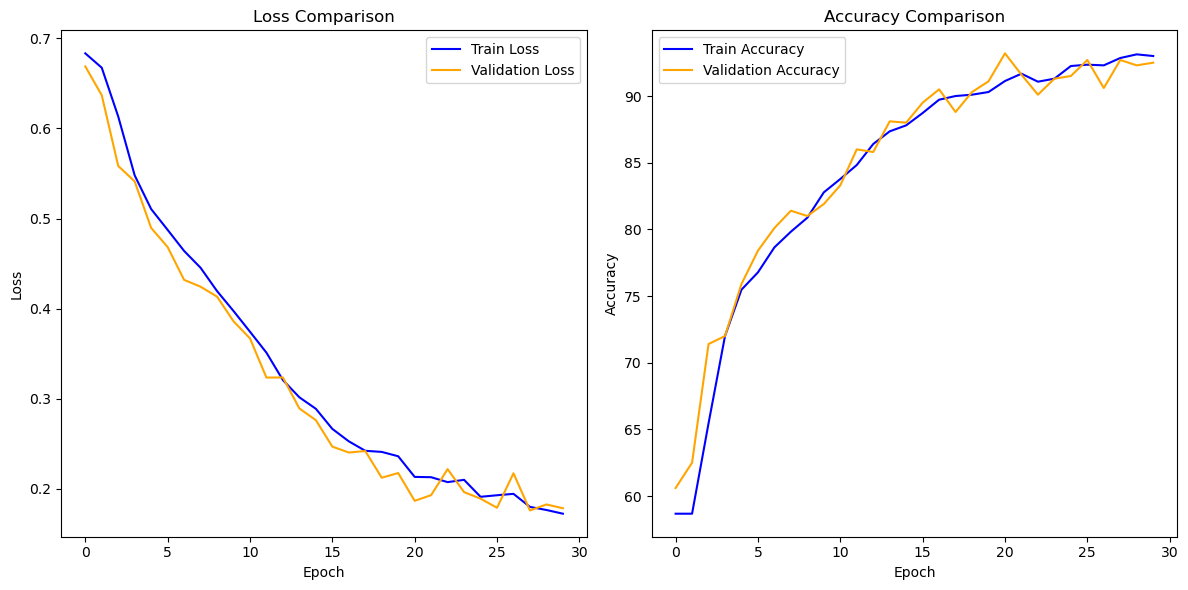

Test Loss: 0.1726, Test Accuracy: 92.80%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

# Define AlexNet model for binary classification with dropout
class AlexNetBinary(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNetBinary, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(256 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])
        if label == -1:
            label = 0  # Change label -1 to 0 for consistency in the model
        if self.transform:
            image = self.transform(image)
        return image, label

# Load CSV file and define dataset
csv_file = 'clean_attribute_indra.csv'
root_dir = 'Images/'
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(25),  # Augmentation: Random rotation
    transforms.RandomHorizontalFlip(),  # Augmentation: Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# Split dataset into train, validation, and test sets
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=50)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, optimizer, and loss function
model = AlexNetBinary()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Lower learning rate
criterion = nn.BCEWithLogitsLoss()

# Training the model with validation
num_epochs = 30
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        predicted_train = torch.round(torch.sigmoid(outputs))
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    
    train_loss_list.append(running_train_loss / len(train_loader))
    train_accuracy_list.append((correct_train / total_train) * 100)
    
    # Evaluate the model on test set
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted_val = torch.round(torch.sigmoid(outputs))
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
    
    val_loss_list.append(val_loss / len(test_loader))
    val_accuracy_list.append((correct_val / total_val) * 100)
    
    end_time = time.time()
    epoch_time = end_time - start_time
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss_list[-1]:.4f}, Train Accuracy: {train_accuracy_list[-1]:.2f}%, '
          f'Validation Loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy_list[-1]:.2f}%, '
          f'Time per Epoch: {epoch_time:.2f} seconds')

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss', color='blue')
plt.plot(val_loss_list, label='Validation Loss', color='orange')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Train Accuracy', color='blue')
plt.plot(val_accuracy_list, label='Validation Accuracy', color='orange')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on test set
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = torch.round(torch.sigmoid(outputs))
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss / len(test_loader), (test_correct / test_total) * 100))

# Save the model
torch.save(model.state_dict(), 'alexnet_custom_30_epoch.pth')


Predicted class: Female
Predicted probability: 0.19400645792484283


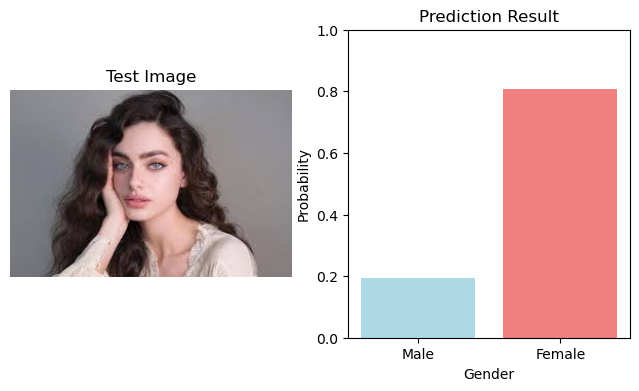

In [9]:
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize(224),
    #transforms.RandomRotation(45),  # Augmentation: Random rotation
    #transforms.RandomHorizontalFlip(),  # Augmentation: Random horizontal flip
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
# Define AlexNet model for binary classification with dropout
class AlexNetBinary(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNetBinary, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(256 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Load the trained model
model = AlexNetBinary()  # Load your trained model here
model.load_state_dict(torch.load('alexnet_custom_30_epoch.pth'))
model.eval()

# Load and preprocess the image
#image_path = 'Images/003847.jpg'  # Provide path to your test image
image_path = 'Images_Prediksi\wanita5.jpeg'
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Make prediction
with torch.no_grad():
    output = model(image_tensor)
    predicted = torch.round(torch.sigmoid(output))  # Round predictions to 0 or 1
    predicted_prob = torch.sigmoid(output).item()

# Print the prediction
predicted_class = 'Male' if predicted.item() == 1 else 'Female'
print("Predicted class:", predicted_class)
print("Predicted probability:", predicted_prob)

# Convert predicted probability to percentage
male_percentage = predicted_prob 
female_percentage = 1 - male_percentage

# Labels untuk sumbu x
labels = ['Male', 'Female']

# Data untuk sumbu y
sizes = [male_percentage, female_percentage]

# Warna untuk setiap bar
colors = ['lightblue', 'lightcoral']


# Plot the percentages
labels = ['Male', 'Female']
sizes = [male_percentage, female_percentage]
colors = ['lightblue', 'lightcoral']

# Display the image and prediction result
plt.figure(figsize=(8, 4))

# Display the image
plt.subplot(1, 2, 1)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Test Image')

# Display the prediction result

plt.subplot(1, 2, 2)
plt.bar(labels, sizes, color=colors)
plt.title('Prediction Result')
plt.xlabel('Gender')
plt.ylabel('Probability')
plt.ylim([0, 1])

plt.show()